In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
import seaborn as sns
import tensorflow as tf
from  tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Resizing
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, RandomRotation, RandomTranslation, RandomFlip, RandomContrast
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import cohen_kappa_score
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
import zipfile
import os

# 압축을 풀 ZIP 파일의 경로를 지정합니다.
zip_path = 'trim_data_2.zip'

# 압축을 풀 위치의 경로를 지정합니다.
extract_path = 'trim_data_Fold'

# ZIP 파일 열기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # 지정된 경로로 모든 내용을 추출합니다.
    zip_ref.extractall(extract_path)

print("압축 해제 완료.")

압축 해제 완료.


In [ ]:
from PIL import Image

# Load the image from a file
original_image = Image.open('./dldata_Fold/train/Rook/Rook_9.jpg')

# Resize the image to 224x224 pixels
resized_image = original_image.resize((224, 224))

# Crop the image to half by cutting off the right side
width, height = resized_image.size
cropped_image = resized_image.crop((0, 0, width , height // 2))

# Save the cropped image to a file
cropped_image.save('path_to_save_cropped_image.jpg')


In [ ]:
import shutil

# 삭제할 폴더의 경로를 지정합니다.
folder_path = 'trim_data_Fold'

# 폴더를 삭제합니다.
shutil.rmtree(folder_path)


In [ ]:
import os
from PIL import Image

# 이미지 파일의 확장자 목록 (필요에 따라 추가 가능)
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']

# 탐색할 최상위 폴더 경로
root_folder = 'dldata_Fold'

# 결과 이미지를 저장할 최상위 폴더
output_root_folder = 'trim_data_Fold'

# root_folder부터 시작하여 모든 디렉토리를 순회
for foldername, subfolders, filenames in os.walk(root_folder):
    for filename in filenames:
        # 파일 확장자가 이미지 확장자 리스트에 있는지 확인
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            # 이미지 파일의 전체 경로 구하기
            image_path = os.path.join(foldername, filename)
            
            # 이미지를 열고 224x224로 크기 조정
            with Image.open(image_path) as img:
                resized_img = img.resize((224, 224))
                
                # 이미지의 하단 절반을 자르고 상단만 남김.
                width, height = resized_img.size
                cropped_img = resized_img.crop((0, 0, width, height//2))
                
                # 원본 폴더 구조를 유지하여 결과 이미지의 경로를 구성.
                relative_path = os.path.relpath(foldername, root_folder)
                output_folder = os.path.join(output_root_folder, relative_path)
                
                # 결과 이미지를 저장할 폴더가 없으면 생성
                if not os.path.exists(output_folder):
                    os.makedirs(output_folder)
                
                # 결과 이미지를 저장할 경로를 구성
                output_image_path = os.path.join(output_folder, filename)
                
                # 결과 이미지를 저장
                cropped_img.save(output_image_path)
                print(f"Processed and saved: {output_image_path}")

print("모든 이미지 처리 완료.")


In [ ]:
import shutil

# Define the directory you want to zip
folder_path = 'trim_data_Fold'  # Replace with your folder path
zip_path = './trim_data_zip'  # Replace with your desired zip output path

# Create a zip archive from the folder
shutil.make_archive(zip_path, 'zip', folder_path)

# The output zip file will be available at 'your_zip_output_path.zip'


In [3]:
base_path = './'

train_df = pd.read_csv(os.path.join(base_path, 'tltrain.csv'))

In [4]:
train_df

,image,label
0,Bishop_0.JPG,Bishop
1,Bishop_1.jpg,Bishop
2,Bishop_10.jpg,Bishop
3,Bishop_11.jpg,Bishop
4,Bishop_12.jpg,Bishop
...,...,...
468,Rook_87.jpg,Rook
469,Rook_88.jpg,Rook
470,Rook_89.jpg,Rook
471,Rook_9.jpg,Rook


In [5]:
train_df.label.value_counts()

Knight    93
Rook      90
Pawn      87
Bishop    75
Queen     66
King      62
Name: label, dtype: int64

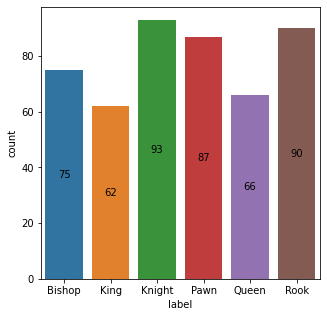

In [6]:
# 데이터 분포

figure = plt.figure(figsize=(5, 5))
ax = figure.add_subplot()
sns.countplot(data=train_df, x='label', ax=ax)

for patch in ax.patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax.text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')
    
plt.show()

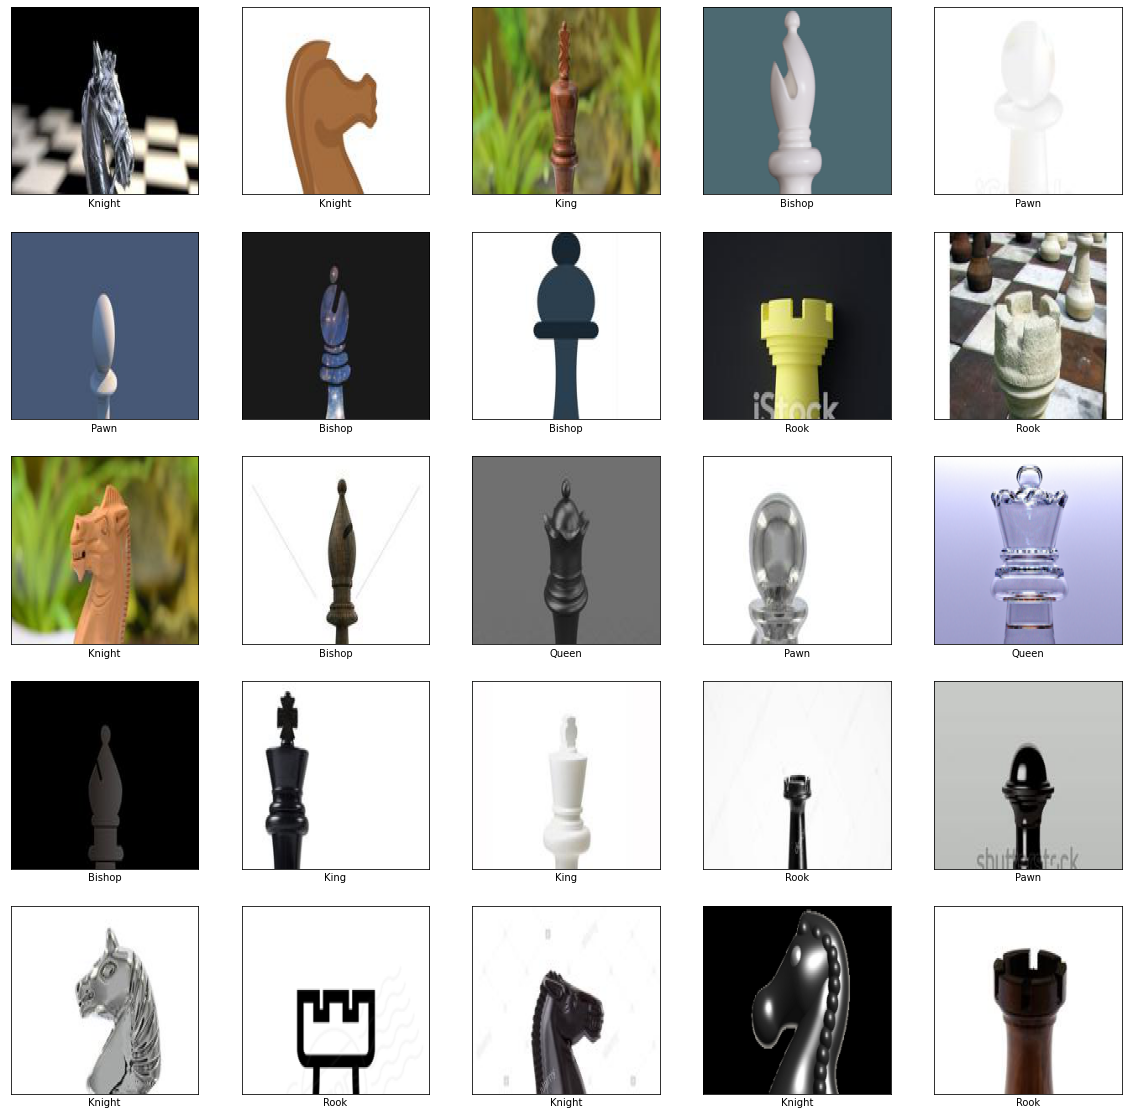

In [7]:
# 이미지 시각화
train_path = base_path +'/trim_data_Fold/trim_data_2/train'

plt.figure(figsize=(20,20))
index = np.random.randint(len(train_df), size=25)
for i in range(25):
    label = train_df['label'][index[i]]
    path_img = train_df['image'][index[i]]
    path_img = os.path.join(train_path, os.path.join(label, path_img))
    
    img = image.load_img(path_img, target_size=(224,224))
    img_tensor = image.img_to_array(img)  # 로드한 이미지를 넘파이 배열로 변환
    img_tensor = np.expand_dims(img_tensor, axis=0)  # 새로운 차원 추가
    img_tensor /= 255.  # 이미지 픽셀값을 [0,255]에서 [0,1]범위로 정규화
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_df, test_size=0.25, stratify=train_df['label'])
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [9]:
train

,image,label
0,Knight_12.jpg,Knight
1,Queen_50.jpg,Queen
2,Rook_15.jpg,Rook
3,Pawn_82.jpg,Pawn
4,Pawn_95.jpg,Pawn
...,...,...
349,Bishop_5.jpg,Bishop
350,Queen_19.jpg,Queen
351,Pawn_26.jpg,Pawn
352,Pawn_25.jpg,Pawn


In [10]:
train['image'] = train['image'].map(lambda x: x.split('_')[0]+'/'+x)
train.head(10)

,image,label
0,Knight/Knight_12.jpg,Knight
1,Queen/Queen_50.jpg,Queen
2,Rook/Rook_15.jpg,Rook
3,Pawn/Pawn_82.jpg,Pawn
4,Pawn/Pawn_95.jpg,Pawn
5,Pawn/Pawn_33.png,Pawn
6,Knight/Knight_47.jpg,Knight
7,Queen/Queen_30.jpg,Queen
8,Rook/Rook_27.jpg,Rook
9,Queen/Queen_35.jpg,Queen


In [11]:
valid['image'] = valid['image'].map(lambda x: x.split('_')[0]+'/'+x)
valid.head(10)

,image,label
0,Rook/Rook_90.jpg,Rook
1,Knight/Knight_34.jpg,Knight
2,Knight/Knight_67.jpg,Knight
3,Pawn/Pawn_73.jpg,Pawn
4,Bishop/Bishop_71.jpg,Bishop
5,Pawn/Pawn_42.jpg,Pawn
6,Pawn/Pawn_0.jpg,Pawn
7,Rook/Rook_71.jpg,Rook
8,Knight/Knight_51.jpg,Knight
9,Bishop/Bishop_67.jpg,Bishop


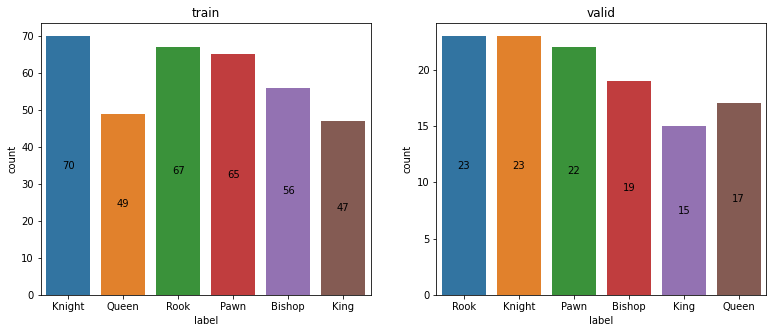

In [12]:
# 분할 후 데이터 분포

figure, ax = plt.subplots(1, 2, figsize=(13,5))
sns.countplot(data=train, x='label', ax=ax[0])
sns.countplot(data=valid, x='label', ax=ax[1])

ax[0].set_title('train')
for patch in ax[0].patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax[0].text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')

ax[1].set_title('valid')
for patch in ax[1].patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax[1].text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')

plt.show()

In [13]:
# 데이터 증강

height, width, channel = (224, 224, 3)
batch_size = 16
labels = ['sunny', 'snow', 'rain', 'dust', 'fog']

train_datagen= ImageDataGenerator(rescale=1./255,
                              rotation_range=20,
                              width_shift_range=0.05,
                              height_shift_range=0.05,
                              zoom_range=[0.7, 1],
                              horizontal_flip=True,  # 좌우대칭
                              vertical_flip=False,   # 상하대칭
                              fill_mode='nearest')



train_generator = train_datagen.flow_from_dataframe(train,
                                                   directory = train_path,
                                                   x_col='image',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))





valid_datagen = ImageDataGenerator(rescale=1. / 255.)

valid_generator = valid_datagen.flow_from_dataframe(valid,
                                                   directory = train_path,
                                                   x_col='image',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))

Found 352 validated image filenames belonging to 6 classes.
Found 118 validated image filenames belonging to 6 classes.


/home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


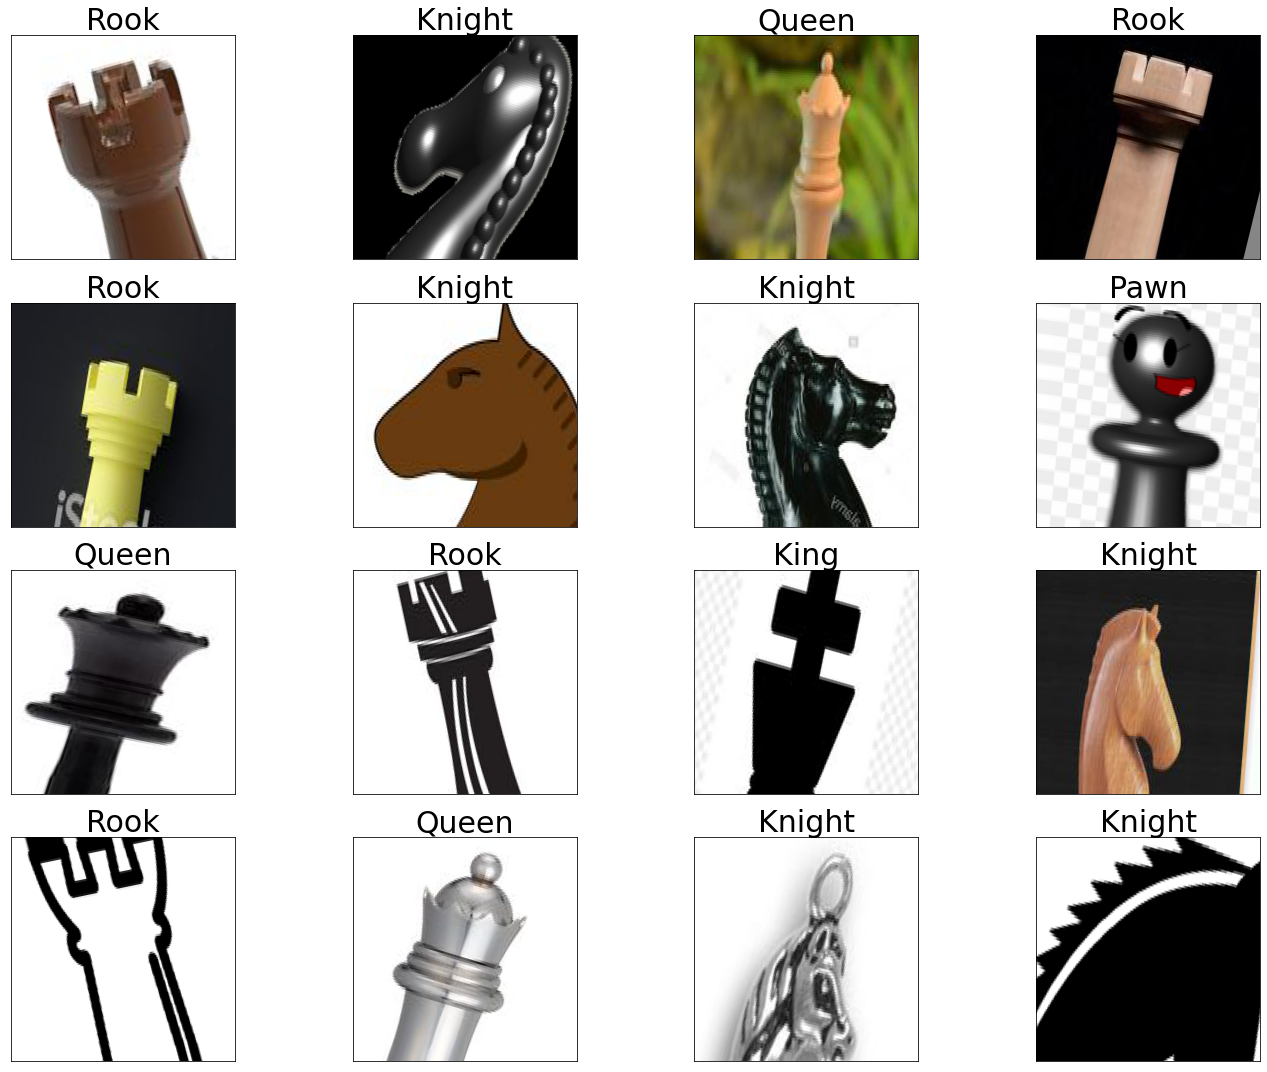

In [14]:
# 데이터 증강 시각화

pred2label={}
for x in train_generator.class_indices.keys():
    pred2label[train_generator.class_indices[x]] = x


plt.figure(figsize=(20,15))
index = np.random.randint(len(train_df), size=batch_size)
x_augs, y_augs = train_generator.next()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_augs[i, :, :, :])
    plt.title(pred2label[np.argmax(y_augs[i, :])], fontsize=30)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.tight_layout()
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

# VGG19 모델 로드
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # Load the VGG19 model without the top layer

# 기존 가중치를 동결 (미세 조정 이전)
base_model.trainable = False 

# 입력 레이어 정의
inputs = tf.keras.Input(shape=(224, 224, 3)) # Input layer

# 이미지를 VGG19 모델을 통과시킴
x = base_model(inputs) 

# Dropout 레이어 추가
x = layers.Dropout(0.4)(x)

# Convolutional 레이어 추가
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.5)(x)
# Convolutional 레이어 추가
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.5)(x)
# Convolutional 레이어 추가
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.5)(x)

# Global Max Pooling2D 레이어 추가
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.6)(x)

# Fully Connected (Dense) 레이어와 Softmax 활성화 함수 추가
x = layers.Dense(6)(x) # Output layer 
outputs = layers.Activation("softmax")(x) 

# 새로운 모델 생성
model = tf.keras.Model(inputs, outputs)

# VGG19 모델의 일부 층을 미세 조정하려면 다음과 같이 설정
for layer in base_model.layers[-5:]:
    layer.trainable = True

# 모델 컴파일
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 모델 요약 출력
model.summary()


2023-11-27 05:06:35.553586: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 05:06:36.207234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d1:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 256)         1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 256)         0     

import tensorflow as tf
from tensorflow.keras import layers

# VGG19 모델 로드
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # Load the VGG19 model without the top layer

# 기존 가중치를 동결 (미세 조정 이전)
base_model.trainable = False 

# 입력 레이어 정의
inputs = tf.keras.Input(shape=(224, 224, 3)) # Input layer

# 이미지를 VGG19 모델을 통과시킴
x = base_model(inputs) 

# Dropout 레이어 추가
x = layers.Dropout(0.4)(x)

# Convolutional 레이어 추가
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.5)(x)
# Convolutional 레이어 추가
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.5)(x)
# Convolutional 레이어 추가
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.5)(x)

# Global Max Pooling2D 레이어 추가
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.6)(x)

# Fully Connected (Dense) 레이어와 Softmax 활성화 함수 추가
x = layers.Dense(6)(x) # Output layer 
outputs = layers.Activation("softmax")(x) 

# 새로운 모델 생성
model = tf.keras.Model(inputs, outputs)

# VGG19 모델의 일부 층을 미세 조정하려면 다음과 같이 설정
for layer in base_model.layers[-5:]:
    layer.trainable = True

# 모델 컴파일
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 모델 요약 출력
model.summary()


In [16]:
print(height,  ' ', width, ' ', channel)

224   224   3


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 256)         1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 256)         0     

In [18]:
# 모델 컴파일 진행 - 아까와 달리 categorical_crossentropy 사용 > label이 숫자형 데이터이므로
model.compile(optimizer = Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])


# 조기멈춤
stop = EarlyStopping(patience=100)

# 자동 저장
checkpoint = ModelCheckpoint("./best_model",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1,save_best_only=True)
callbacks = [stop, checkpoint]

# 모델 fitting
save = model.fit(train_generator,epochs = 2000, validation_data=valid_generator, batch_size=32, callbacks=callbacks)

2023-11-27 05:07:05.102761: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000


2023-11-27 05:07:07.462656: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-11-27 05:07:15.631931: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


22/22 [==============================] - 20s 395ms/step - loss: 3.3581 - accuracy: 0.1733 - val_loss: 1.7883 - val_accuracy: 0.2373

Epoch 00001: val_accuracy improved from -inf to 0.23729, saving model to ./best_model
Epoch 2/2000
22/22 [==============================] - 5s 229ms/step - loss: 1.8649 - accuracy: 0.1676 - val_loss: 1.7709 - val_accuracy: 0.4407

Epoch 00002: val_accuracy improved from 0.23729 to 0.44068, saving model to ./best_model
Epoch 3/2000
22/22 [==============================] - 5s 224ms/step - loss: 1.6993 - accuracy: 0.2756 - val_loss: 1.6934 - val_accuracy: 0.3898

Epoch 00003: val_accuracy did not improve from 0.44068
Epoch 4/2000
22/22 [==============================] - 5s 224ms/step - loss: 1.5550 - accuracy: 0.3551 - val_loss: 1.5338 - val_accuracy: 0.6186

Epoch 00004: val_accuracy improved from 0.44068 to 0.61864, saving model to ./best_model
Epoch 5/2000
22/22 [==============================] - 5s 224ms/step - loss: 1.3022 - accuracy: 0.4432 - val_loss:

22/22 [==============================] - 5s 215ms/step - loss: 0.3242 - accuracy: 0.8807 - val_loss: 0.4379 - val_accuracy: 0.8814

Epoch 00040: val_accuracy did not improve from 0.90678
Epoch 41/2000
22/22 [==============================] - 5s 238ms/step - loss: 0.2714 - accuracy: 0.8977 - val_loss: 0.3588 - val_accuracy: 0.9153

Epoch 00041: val_accuracy improved from 0.90678 to 0.91525, saving model to ./best_model
Epoch 42/2000
22/22 [==============================] - 5s 224ms/step - loss: 0.2412 - accuracy: 0.9176 - val_loss: 0.3597 - val_accuracy: 0.9153

Epoch 00042: val_accuracy did not improve from 0.91525
Epoch 43/2000
22/22 [==============================] - 5s 222ms/step - loss: 0.2561 - accuracy: 0.9062 - val_loss: 0.3765 - val_accuracy: 0.9237

Epoch 00043: val_accuracy improved from 0.91525 to 0.92373, saving model to ./best_model
Epoch 44/2000
22/22 [==============================] - 5s 216ms/step - loss: 0.2108 - accuracy: 0.9290 - val_loss: 0.3792 - val_accuracy: 0.90


Epoch 00080: val_accuracy did not improve from 0.92373
Epoch 81/2000
22/22 [==============================] - 5s 238ms/step - loss: 0.1710 - accuracy: 0.9432 - val_loss: 0.3937 - val_accuracy: 0.8814

Epoch 00081: val_accuracy did not improve from 0.92373
Epoch 82/2000
22/22 [==============================] - 5s 219ms/step - loss: 0.1710 - accuracy: 0.9318 - val_loss: 0.3958 - val_accuracy: 0.9068

Epoch 00082: val_accuracy did not improve from 0.92373
Epoch 83/2000
22/22 [==============================] - 5s 222ms/step - loss: 0.1664 - accuracy: 0.9432 - val_loss: 0.3526 - val_accuracy: 0.9068

Epoch 00083: val_accuracy did not improve from 0.92373
Epoch 84/2000
22/22 [==============================] - 5s 223ms/step - loss: 0.2253 - accuracy: 0.9460 - val_loss: 0.4099 - val_accuracy: 0.9153

Epoch 00084: val_accuracy did not improve from 0.92373
Epoch 85/2000
22/22 [==============================] - 5s 211ms/step - loss: 0.1401 - accuracy: 0.9631 - val_loss: 0.3954 - val_accuracy: 0.

22/22 [==============================] - 5s 229ms/step - loss: 0.1024 - accuracy: 0.9545 - val_loss: 0.3851 - val_accuracy: 0.8898

Epoch 00161: val_accuracy did not improve from 0.94915
Epoch 162/2000
22/22 [==============================] - 5s 223ms/step - loss: 0.1370 - accuracy: 0.9744 - val_loss: 0.3416 - val_accuracy: 0.9407

Epoch 00162: val_accuracy did not improve from 0.94915
Epoch 163/2000
22/22 [==============================] - 5s 222ms/step - loss: 0.1392 - accuracy: 0.9631 - val_loss: 0.3436 - val_accuracy: 0.9068

Epoch 00163: val_accuracy did not improve from 0.94915
Epoch 164/2000
22/22 [==============================] - 5s 219ms/step - loss: 0.1390 - accuracy: 0.9688 - val_loss: 0.3455 - val_accuracy: 0.9237

Epoch 00164: val_accuracy did not improve from 0.94915
Epoch 165/2000
22/22 [==============================] - 5s 225ms/step - loss: 0.1174 - accuracy: 0.9574 - val_loss: 0.4345 - val_accuracy: 0.8475

Epoch 00165: val_accuracy did not improve from 0.94915
Epoch


Epoch 00201: val_accuracy did not improve from 0.94915
Epoch 202/2000
22/22 [==============================] - 5s 224ms/step - loss: 0.0899 - accuracy: 0.9773 - val_loss: 0.3530 - val_accuracy: 0.9322

Epoch 00202: val_accuracy did not improve from 0.94915
Epoch 203/2000
22/22 [==============================] - 5s 225ms/step - loss: 0.0680 - accuracy: 0.9886 - val_loss: 0.3605 - val_accuracy: 0.9237

Epoch 00203: val_accuracy did not improve from 0.94915
Epoch 204/2000
22/22 [==============================] - 5s 227ms/step - loss: 0.1337 - accuracy: 0.9744 - val_loss: 0.3450 - val_accuracy: 0.9237

Epoch 00204: val_accuracy did not improve from 0.94915
Epoch 205/2000
22/22 [==============================] - 5s 225ms/step - loss: 0.0598 - accuracy: 0.9773 - val_loss: 0.3565 - val_accuracy: 0.9322

Epoch 00205: val_accuracy did not improve from 0.94915
Epoch 206/2000
22/22 [==============================] - 5s 225ms/step - loss: 0.1459 - accuracy: 0.9545 - val_loss: 0.5486 - val_accurac

In [19]:
test_df = pd.read_csv(base_path + "/tltest.csv")
test_df.head(5)

,image,label
0,test_0.jpg,NaN
1,test_1.jpg,NaN
2,test_2.jpg,NaN
3,test_3.jpg,NaN
4,test_4.jpg,NaN


In [20]:
batch_size = len(test_df["image"])
height, width, channel = 224, 224, 3

In [21]:
# 테스트 이미지를 메모리에 올림.
test_path = base_path + 'trim_data_Fold/trim_data_2/test'

test_image = np.zeros((batch_size, height, width, channel))
print(test_image.shape)
cnt=0
for i in range(len(test_df["image"])):
    path_img = test_df['image'][i]
    img = image.load_img(os.path.join(test_path,path_img), target_size=(height, width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.array(img_tensor,dtype="float32")

    img_tensor /= 255
    
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    test_image[i] = img_tensor

(60, 224, 224, 3)


In [22]:
predictions = model.predict(test_image)
predictions.shape

(60, 6)

In [23]:
test_df['label'] = [pred2label[np.argmax(pred)] for pred in predictions]
test_df

,image,label
0,test_0.jpg,Bishop
1,test_1.jpg,Bishop
2,test_2.jpg,Bishop
3,test_3.jpg,Queen
4,test_4.jpg,King
5,test_5.jpg,Rook
6,test_6.jpg,Bishop
7,test_7.jpg,Bishop
8,test_8.jpg,Rook
9,test_9.jpg,Bishop


In [24]:
test_df.to_csv('./6th_sub.csv', index=False)